<a href="https://colab.research.google.com/github/Luc1lfer/SoftEng/blob/main/bago_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
pip install --upgrade scipy


In [10]:
pip install --upgrade pip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [13]:
!pip install --upgrade scipy

Dropping columns with >90.0% missing values: ['Growth Rate (%)', 'Innovation Index', 'Awareness Campaign Impact']
NaN values in processed_df after one-hot encoding:
 Year                                                 0
Market Size (USD Million)                            0
CAGR(%)                                              0
Market Penetration                                   0
Market Share (%)                                     0
Revenue Contribution (%)                             0
Regulatory Impact                                    0
Material Type_Latex                                  0
Material Type_Non-latex                              0
Product Type_Female Condoms                          0
Product Type_Male Condoms                            0
Distribution Channel_Drug Stores                     0
Distribution Channel_E-Commerce                      0
Distribution Channel_Mass Merchandisers              0
Event Name_Acquisition                               0
Event Nam

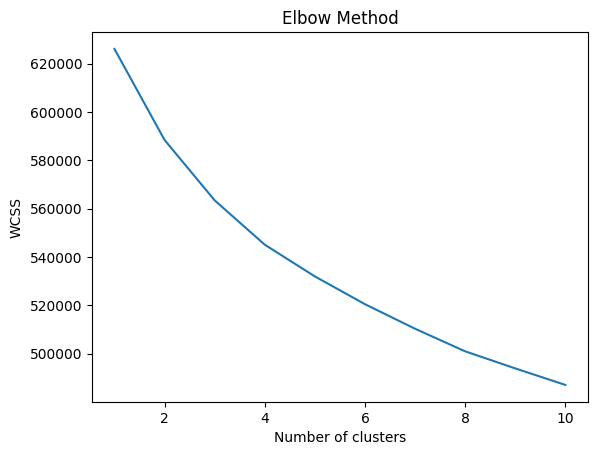

For n_clusters = 2 The average silhouette_score is : 0.05838313922748459
For n_clusters = 3 The average silhouette_score is : 0.051288366798832585
For n_clusters = 4 The average silhouette_score is : 0.053483614370939465
For n_clusters = 5 The average silhouette_score is : 0.04964398662703457
For n_clusters = 6 The average silhouette_score is : 0.04864138324189976
For n_clusters = 7 The average silhouette_score is : 0.04937010921998891
For n_clusters = 8 The average silhouette_score is : 0.0498138862557084
For n_clusters = 9 The average silhouette_score is : 0.0482580247875411
For n_clusters = 10 The average silhouette_score is : 0.048574017063394974


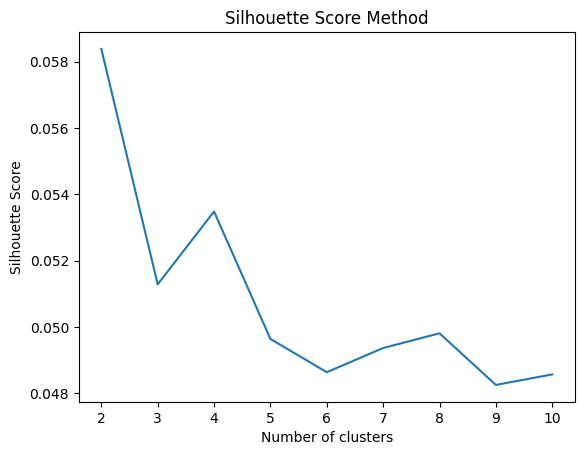

  Brand Name       Region  Cluster
0      Durex   West India        1
1    Playboy   West India        2
2      Skore  North India        0
3      Durex   West India        0
4      Skore  South India        1


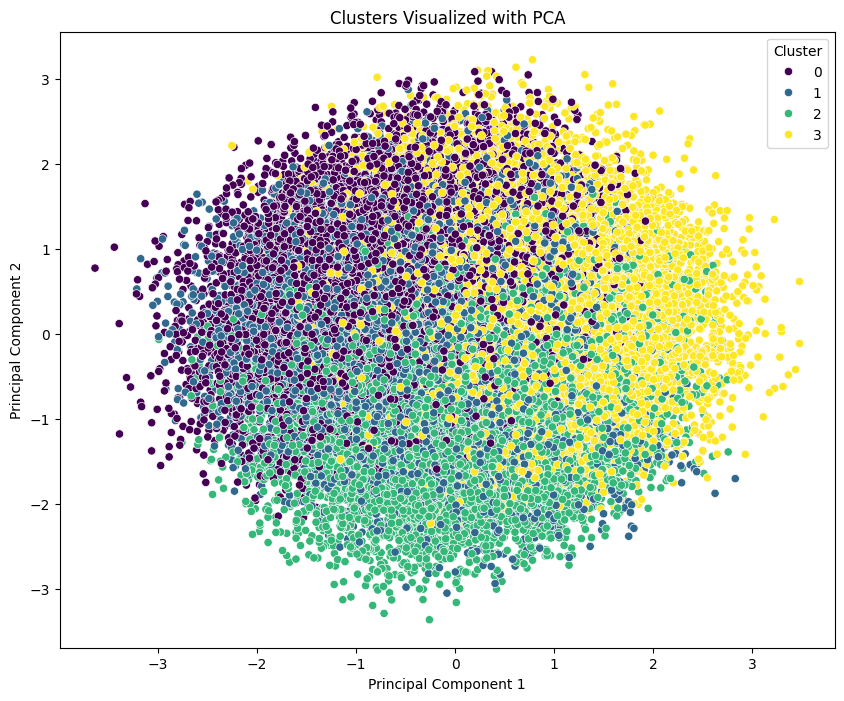

         Market Size (USD Million)    CAGR(%)  Market Penetration  \
Cluster                                                             
0                      1397.778261  10.519277            2.250840   
1                      1394.844282  10.506503            1.227315   
2                      1397.111015  10.478180            1.744650   
3                      1404.912005  10.525542            2.765071   

         Regulatory Impact  Market Share (%)  Revenue Contribution (%)  \
Cluster                                                                  
0                 1.359609         22.385143                  4.424665   
1                 2.692705         22.595973                  6.434907   
2                 1.361512         22.705492                 11.569056   
3                 2.702943         22.410568                  9.537154   

        Material Type    Product Type Distribution Channel       Region  \
Cluster                                                          

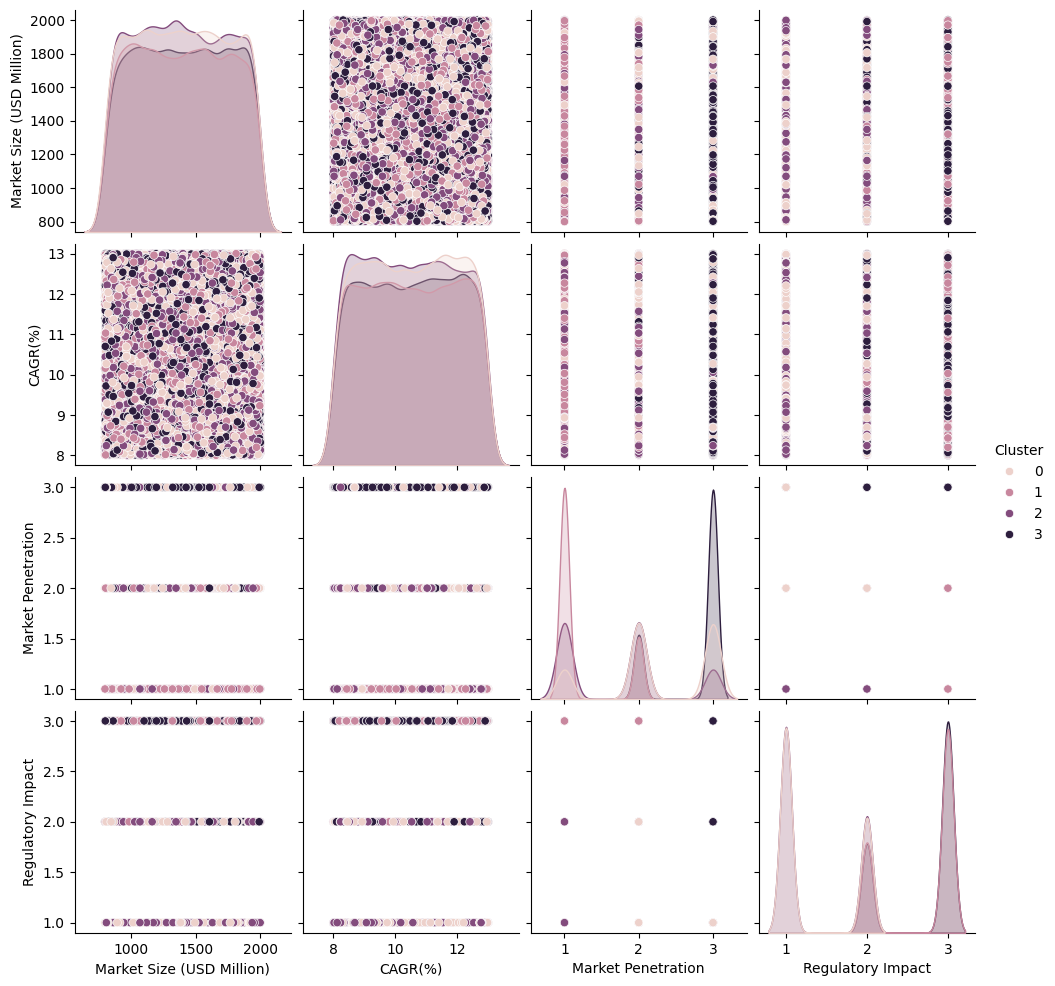

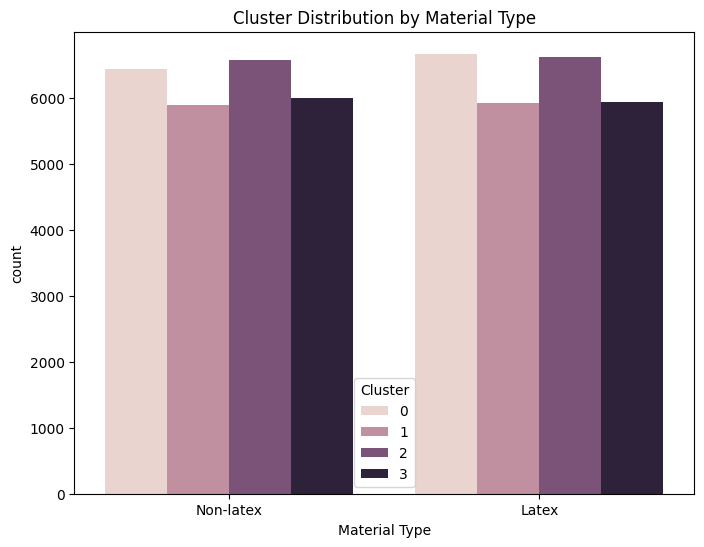

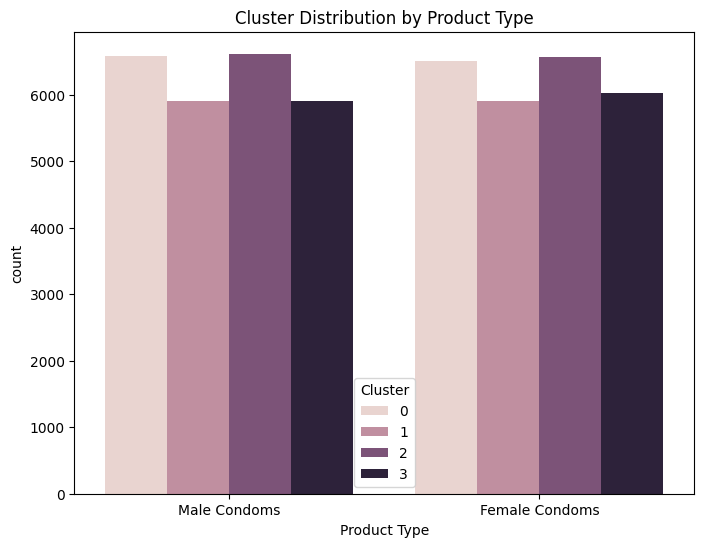

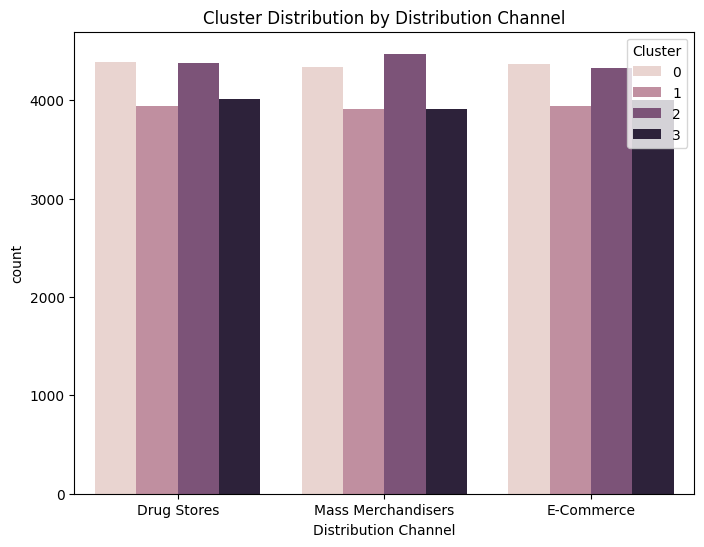

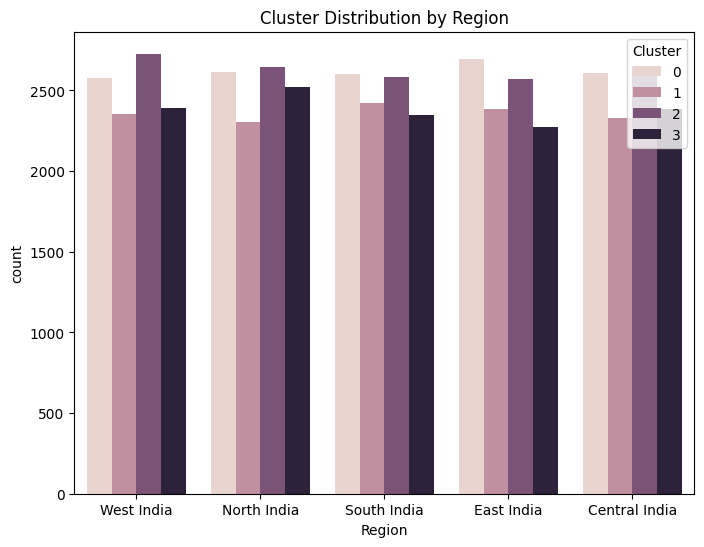

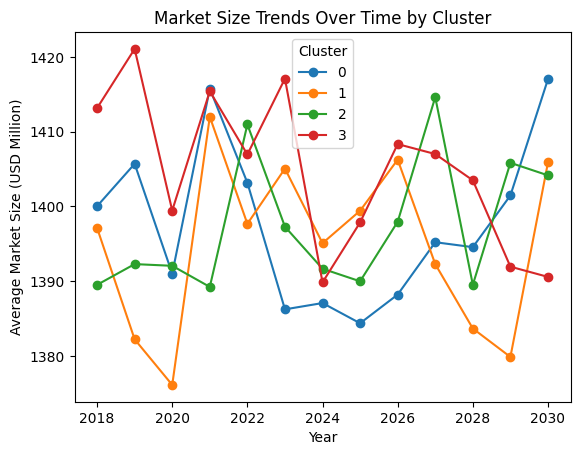

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Step 1: Load and Inspect the Data
data = pd.read_csv('India_Condom_Market_Dataset.csv')

# Step 2: Handle Date-Related Columns
data['Event Date'] = pd.to_datetime(data['Event Date'], errors='coerce')
data['Year'] = data['Event Date'].dt.year  # Extract year for time series analysis
data.drop('Event Date', axis=1, inplace=True)

# Step 3: Clean and Transform Features
data.rename(columns={'CAGR (%)': 'CAGR(%)'}, inplace=True)
mapping = {'Low': 1, 'Medium': 2, 'High': 3}  # More robust handling of missing mappings
for col in ['Market Penetration', 'Growth Rate (%)', 'Innovation Index', 'Regulatory Impact', 'Awareness Campaign Impact']:
    data[col] = data[col].map(mapping)

# Step 4: Identify and Remove Columns with >90% Missing Values
missing_threshold = 0.9  # Threshold for missing data
initial_cols = data.columns
missing_counts = data.isnull().sum() / len(data)
cols_to_drop = missing_counts[missing_counts > missing_threshold].index
print(f"Dropping columns with >{missing_threshold*100}% missing values: {list(cols_to_drop)}")
data.drop(cols_to_drop, axis=1, inplace=True)
final_cols = data.columns

# Step 5: Impute Numerical Features
numerical_features = data.select_dtypes(include=np.number).columns.tolist()
categorical_features = data.select_dtypes(exclude=np.number).columns.tolist()
# Remove any dropped column from the list of numerical features
numerical_features = [col for col in numerical_features if col in final_cols]

# Imputation using SimpleImputer
imputer = SimpleImputer(strategy='mean')
data[numerical_features] = imputer.fit_transform(data[numerical_features])

# Step 6: Define Features and Create Subset
all_features = numerical_features + categorical_features
# Step 7: Create ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Step 8: Fit and Transform Data
processed_data = preprocessor.fit_transform(data)

# Step 9: Create Processed DataFrame
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
processed_df = pd.DataFrame(processed_data,
                            columns=numerical_features + list(ohe_feature_names))

# Step 10: Check for NaN values in processed_df
print("NaN values in processed_df after one-hot encoding:\n", processed_df.isnull().sum())

# Step 11: Drop the all-NaN columns from processed_df
processed_df.drop(columns=[col for col in initial_cols if col not in final_cols], errors='ignore', inplace=True)

# Step 12: Check if there are any remaining NaN values
print("Remaining NaN values in processed_df after dropping all-NaN columns:\n", processed_df.isnull().sum())

# Step 13: K-Means Clustering
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(processed_df)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Silhouette Score Method
silhouette_scores = []
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster, init='k-means++', max_iter=300, n_init=10, random_state=0)
    cluster_labels = kmeans.fit_predict(processed_df)
    silhouette_avg = silhouette_score(processed_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print("For n_clusters =", n_cluster,
          "The average silhouette_score is :", silhouette_avg)

plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Choose the optimal number of clusters (e.g., 4 based on the Elbow Method)
n_clusters = 4

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels = kmeans.fit_predict(processed_df)

# Create a mapping from original index to cluster label
cluster_mapping = dict(zip(processed_df.index, cluster_labels))

# Map the cluster labels back to the original dataframe, preserving the index
data['Cluster'] = data.index.map(cluster_mapping)

# Display cluster assignments
print(data[['Brand Name', 'Region', 'Cluster']].head())

# Step 14.5: Apply PCA for Visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(processed_df)

# Create a PCA DataFrame
pca_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'])
pca_df['Cluster'] = data['Cluster']

# Step 14.6: Plot the Clusters using PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis')
plt.title('Clusters Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Step 15: Analyze Cluster Characteristics
cluster_summary = data.groupby('Cluster').agg({
    'Market Size (USD Million)': 'mean',
    'CAGR(%)': 'mean',
    'Market Penetration': 'mean',
    # 'Growth Rate (%)': 'mean', # Removed because some of these are not in the DataFrame.
    # 'Innovation Index': 'mean',
    # 'Awareness Campaign Impact': 'mean',
    'Regulatory Impact': 'mean',
    'Market Share (%)': 'mean',
    'Revenue Contribution (%)':'mean',
    'Material Type': lambda x: x.value_counts().index[0],
    'Product Type': lambda x: x.value_counts().index[0],
    'Distribution Channel': lambda x: x.value_counts().index[0],
    'Region': lambda x: x.value_counts().index[0],
    'Brand Name': lambda x: x.value_counts().index[0]
})

print(cluster_summary)

# Step 16: Visualize Results
sns.pairplot(data, hue='Cluster', vars=['Market Size (USD Million)', 'CAGR(%)', 'Market Penetration', 'Regulatory Impact'])
plt.show()

for feature in ['Material Type', 'Product Type', 'Distribution Channel', 'Region']:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=data, x=feature, hue='Cluster')
    plt.title(f'Cluster Distribution by {feature}')
    plt.show()

# Step 17: Time Series Analysis
yearly_cluster_summary = data.groupby(['Year', 'Cluster'])['Market Size (USD Million)'].mean().unstack()
yearly_cluster_summary.plot(kind='line', marker='o')
plt.title('Market Size Trends Over Time by Cluster')
plt.xlabel('Year')
plt.ylabel('Average Market Size (USD Million)')
plt.legend(title='Cluster')
plt.show()
